# Gender Recognition from Voice – Giulia Stefania's Module

**Overview**  
This notebook demonstrates a voice gender classifier using knowledge distillation: a pre-trained Wav2Vec2 teacher provides pseudo-labels for LibriSpeech data, then we train lightweight students (GMM and MLP).  

**Key Experiments**  
- Baseline: GMM on mean MFCC (13-dim)  
- Enhanced: GMM on MFCC mean/std + pitch mean/std (28-dim)  
- Noise robustness test  
- Model comparison: GMM vs MLP on both feature sets  
- Pitch distribution visualization

In [1]:
!pip install torch torchaudio transformers datasets scikit-learn librosa soundfile seaborn matplotlib -q

## 1. Imports & Configuration

In [2]:
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from datasets import load_dataset
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import warnings
import pandas as pd

TRAIN_SAMPLES = 1500
TEST_SAMPLES  = 500
SAMPLE_RATE   = 16000

warnings.filterwarnings("ignore")
plt.style.use('ggplot')

print(f"Ready. Target: {TRAIN_SAMPLES:,} train + {TEST_SAMPLES:,} test samples.")

/Users/giulia/Desktop/master/bd/proiect/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ready. Target: 1,500 train + 500 test samples.


## 2. ETL Pipeline – Collect data with teacher pseudo-labels + raw audio

We stream LibriSpeech, get gender pseudo-labels from the pre-trained teacher, extract basic mean MFCC for baseline, and save raw audio for later feature enhancement.

In [3]:
print("--- Streaming ETL Pipeline (LibriSpeech clean) ---")

try:
    dataset = load_dataset("librispeech_asr", "clean", split="train.100", streaming=True)
    print("Stream connected.")
except Exception as e:
    sys.exit(f"Connection Failed: {e}")

model_name = "alefiury/wav2vec2-large-xlsr-53-gender-recognition-librispeech"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
teacher_model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name)
print("Teacher model loaded.")

data_train = {'male': [], 'female': []}
data_test = []
collected_train = 0
collected_test = 0

for sample in dataset:
    if collected_train >= TRAIN_SAMPLES and collected_test >= TEST_SAMPLES:
        break

    audio = sample['audio']['array']
    sr = sample['audio']['sampling_rate']
    
    if sr != SAMPLE_RATE:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
    
    if len(audio) < SAMPLE_RATE * 0.5 or len(audio) > SAMPLE_RATE * 6:
        continue

    inputs = feature_extractor(audio, sampling_rate=SAMPLE_RATE, return_tensors="pt", padding=True)
    with torch.no_grad():
        logits = teacher_model(inputs.input_values).logits
    pred_id = torch.argmax(logits, dim=-1).item()
    
    raw_lbl = teacher_model.config.id2label[pred_id].lower()
    gender = 'female' if 'fem' in raw_lbl else 'male'

    mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=13)
    mfcc_mean = np.mean(mfcc.T, axis=0)

    sample_dict = {
        'mfcc_mean': mfcc_mean,
        'audio': audio.copy(),
        'label': gender
    }

    if collected_train < TRAIN_SAMPLES:
        if len(data_train[gender]) < TRAIN_SAMPLES // 2:
            data_train[gender].append(sample_dict)
            collected_train += 1
            if collected_train % 200 == 0:
                print(f"  Train: {collected_train}/{TRAIN_SAMPLES}")
    elif collected_test < TEST_SAMPLES:
        data_test.append(sample_dict)
        collected_test += 1
        if collected_test % 100 == 0:
            print(f"  Test: {collected_test}/{TEST_SAMPLES}")

print("\nPipeline finished.")
print(f"Train: {len(data_train['male'])} male + {len(data_train['female'])} female")
print(f"Test : {len(data_test)} samples")

--- Streaming ETL Pipeline (LibriSpeech clean) ---
Stream connected.
Teacher model loaded.
  Train: 200/1500
  Train: 400/1500
  Train: 600/1500
  Train: 800/1500
  Train: 1000/1500
  Train: 1200/1500
  Train: 1400/1500
  Test: 100/500
  Test: 200/500
  Test: 300/500
  Test: 400/500
  Test: 500/500

Pipeline finished.
Train: 750 male + 750 female
Test : 500 samples


## 3. Baseline – GMM on simple mean MFCC (13 dimensions)
Simple classical baseline for comparison

--- Baseline GMM (mean MFCC only) ---
Baseline accuracy: 68.80%


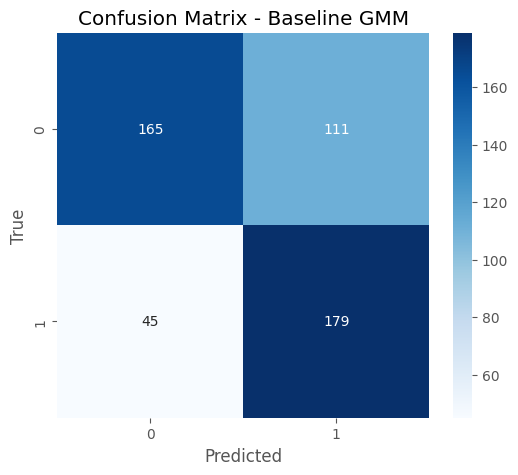

In [4]:
print("--- Baseline GMM (mean MFCC only) ---")

gmm_male_base = GaussianMixture(n_components=16, covariance_type='diag', random_state=42)
gmm_female_base = GaussianMixture(n_components=16, covariance_type='diag', random_state=42)

gmm_male_base.fit([s['mfcc_mean'] for s in data_train['male']])
gmm_female_base.fit([s['mfcc_mean'] for s in data_train['female']])

y_true = [item['label'] for item in data_test]
y_true_num = [1 if l == 'female' else 0 for l in y_true]

y_pred_base = []

for item in data_test:
    score_m = gmm_male_base.score(item['mfcc_mean'].reshape(1, -1))
    score_f = gmm_female_base.score(item['mfcc_mean'].reshape(1, -1))
    y_pred_base.append('female' if score_f > score_m else 'male')

acc_base = accuracy_score(y_true, y_pred_base)

print(f"Baseline accuracy: {acc_base:.2%}")

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_true, y_pred_base, labels=['male','female']),
            annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Baseline GMM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 4. Enhanced Features – MFCC mean/std + voiced pitch mean/std (28 dimensions)

We extract richer features from raw audio:  
- MFCC mean & std per coefficient (captures variability)  
- Voiced fundamental frequency (F0) mean & std via pyin (strong gender cue)  

Then retrain GMM on the new 28-dim representation.

In [5]:
print("=== Enhanced Features (28-dim) ===")

def extract_enhanced_features(audio):
    mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std  = np.std(mfcc, axis=1)
    
    f0, voiced_flag, _ = librosa.pyin(
        audio,
        fmin=librosa.note_to_hz('C2'),
        fmax=librosa.note_to_hz('C7'),
        sr=SAMPLE_RATE,
        frame_length=1024,
        hop_length=256,
        fill_na=np.nan
    )
    voiced_f0 = f0[voiced_flag & ~np.isnan(f0)]
    pitch_mean = np.mean(voiced_f0) if len(voiced_f0) > 0 else 120.0
    pitch_std  = np.std(voiced_f0) if len(voiced_f0) > 0 else 20.0
    
    return np.concatenate([mfcc_mean, mfcc_std, [pitch_mean, pitch_std]])

# Extract
enhanced_train_male   = [extract_enhanced_features(s['audio']) for s in data_train['male']]
enhanced_train_female = [extract_enhanced_features(s['audio']) for s in data_train['female']]
enhanced_test_feats   = [extract_enhanced_features(item['audio']) for item in data_test]

# Retrain GMM
gmm_male_enh = GaussianMixture(n_components=16, covariance_type='diag', random_state=42)
gmm_female_enh = GaussianMixture(n_components=16, covariance_type='diag', random_state=42)

gmm_male_enh.fit(enhanced_train_male)
gmm_female_enh.fit(enhanced_train_female)

# Evaluate
y_pred_enh = []
for feat in enhanced_test_feats:
    score_m = gmm_male_enh.score(feat.reshape(1, -1))
    score_f = gmm_female_enh.score(feat.reshape(1, -1))
    y_pred_enh.append('female' if score_f > score_m else 'male')

acc_enh = accuracy_score(y_true, y_pred_enh)

print(f"Enhanced GMM accuracy: {acc_enh:.2%}")
print(f"Gain over baseline: {acc_enh - acc_base:+.2%}")

=== Enhanced Features (28-dim) ===
Enhanced GMM accuracy: 92.80%
Gain over baseline: +24.00%


## 5. Pitch Distribution

Generating pitch distribution...


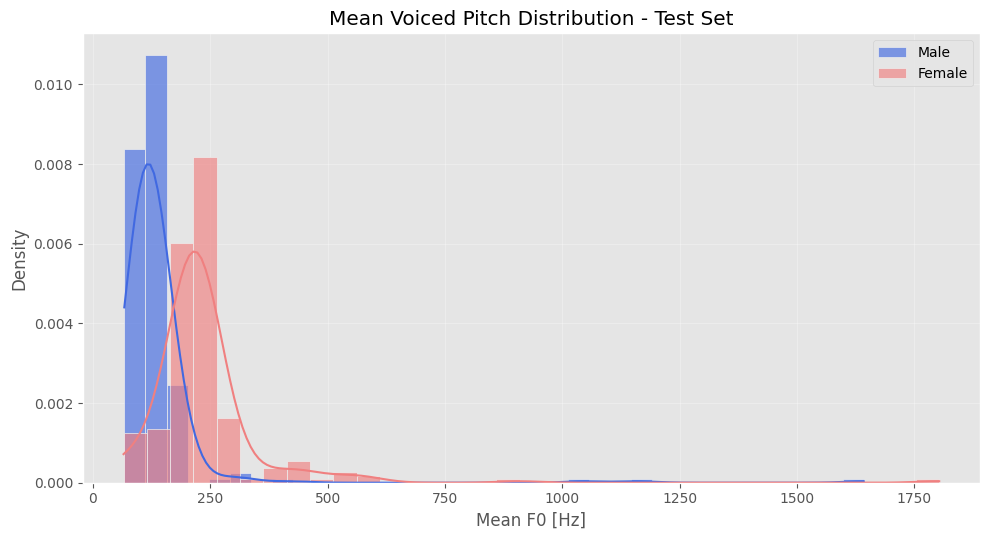

In [6]:
print("Generating pitch distribution...")

pitch_male = []
pitch_female = []

for item in data_test:
    f0, voiced_flag, _ = librosa.pyin(item['audio'], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=SAMPLE_RATE)
    voiced_f0 = f0[voiced_flag]
    mean_pitch = np.mean(voiced_f0) if len(voiced_f0) > 0 else np.nan
    if item['label'] == 'male':
        pitch_male.append(mean_pitch)
    else:
        pitch_female.append(mean_pitch)

pitch_male   = np.array([p for p in pitch_male if not np.isnan(p)])
pitch_female = np.array([p for p in pitch_female if not np.isnan(p)])

if len(pitch_male) > 0 and len(pitch_female) > 0:
    plt.figure(figsize=(10, 5.5))
    sns.histplot(pitch_male,   bins=35, color='royalblue', kde=True, stat='density', label='Male', alpha=0.65)
    sns.histplot(pitch_female, bins=35, color='lightcoral', kde=True, stat='density', label='Female', alpha=0.65)
    plt.title("Mean Voiced Pitch Distribution - Test Set")
    plt.xlabel("Mean F0 [Hz]")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough voiced pitch data for histogram.")

## 6. Noise Robustness Study

We add controlled Gaussian noise to raw audio, re-extract enhanced features, and see how accuracy drops.

=== Noise Robustness Study ===
Noise std=0.000 → accuracy = 92.80%
Noise std=0.005 → accuracy = 77.00%
Noise std=0.010 → accuracy = 62.20%
Noise std=0.020 → accuracy = 45.60%


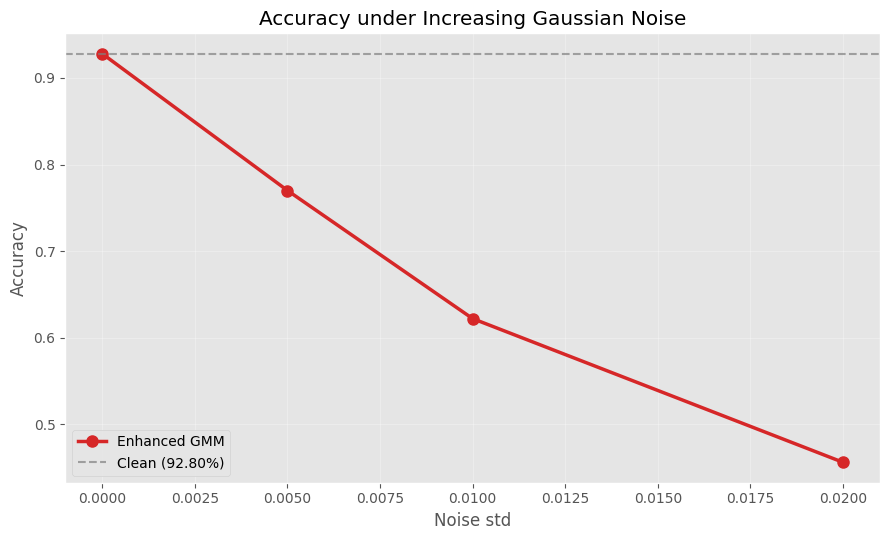

In [7]:
print("=== Noise Robustness Study ===")

def add_gaussian_noise(audio, std=0.008):
    noise = np.random.normal(0, std, len(audio))
    return np.clip(audio + noise, -1.0, 1.0)

noise_levels = [0.0, 0.005, 0.01, 0.02]
acc_noisy = []

for std in noise_levels:
    noisy_feats = [extract_enhanced_features(add_gaussian_noise(item['audio'], std)) for item in data_test]
    preds = []
    for feat in noisy_feats:
        s_m = gmm_male_enh.score(feat.reshape(1,-1))
        s_f = gmm_female_enh.score(feat.reshape(1,-1))
        preds.append('female' if s_f > s_m else 'male')
    acc = accuracy_score(y_true, preds)
    acc_noisy.append(acc)
    print(f"Noise std={std:.3f} → accuracy = {acc:.2%}")

plt.figure(figsize=(9,5.5))
plt.plot(noise_levels, acc_noisy, marker='o', color='#d62728', lw=2.5, markersize=8, label='Enhanced GMM')
plt.axhline(acc_enh, color='gray', ls='--', alpha=0.7, label=f'Clean ({acc_enh:.2%})')
plt.title("Accuracy under Increasing Gaussian Noise")
plt.xlabel("Noise std")
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 7. Model Comparison – GMM vs MLP on both feature sets

We compare classical GMM with a simple MLP neural network on both original 13-dim and enhanced 28-dim features.

=== Model Comparison ===

Comparison Table:
     Model  Accuracy
GMM 28-dim     0.928
MLP 28-dim     0.884
MLP 13-dim     0.768
GMM 13-dim     0.688


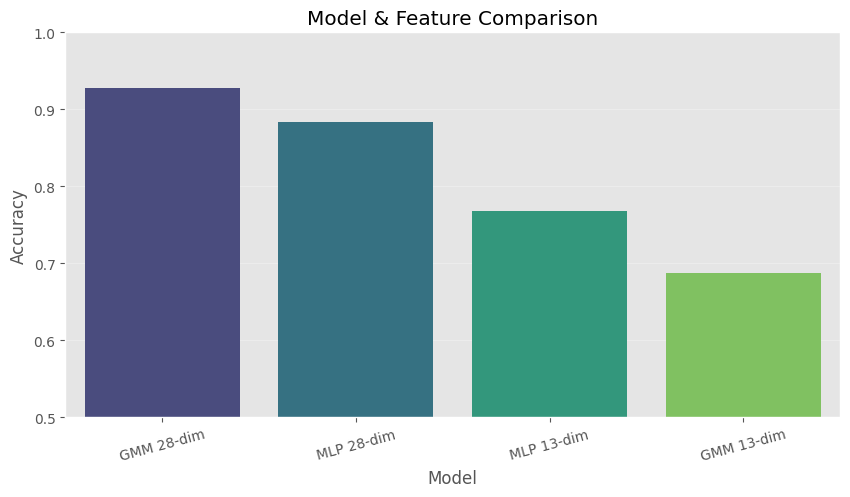

In [8]:
# %%
print("=== Model Comparison ===")

# MLP on 13-dim
X_train_13 = np.vstack([s['mfcc_mean'] for s in data_train['male'] + data_train['female']])
y_train_num = [0] * len(data_train['male']) + [1] * len(data_train['female'])

scaler_13 = StandardScaler().fit(X_train_13)
mlp_13 = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=400, random_state=42)
mlp_13.fit(scaler_13.transform(X_train_13), y_train_num)

X_test_13 = np.vstack([item['mfcc_mean'] for item in data_test])
y_pred_mlp_13 = mlp_13.predict(scaler_13.transform(X_test_13))
acc_mlp_13 = accuracy_score(y_true_num, y_pred_mlp_13)

# MLP on 28-dim
X_train_28 = enhanced_train_male + enhanced_train_female
scaler_28 = StandardScaler().fit(X_train_28)
mlp_28 = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=400, random_state=42)
mlp_28.fit(scaler_28.transform(X_train_28), y_train_num)

X_test_28 = enhanced_test_feats
y_pred_mlp_28 = mlp_28.predict(scaler_28.transform(X_test_28))
acc_mlp_28 = accuracy_score(y_true_num, y_pred_mlp_28)

results = pd.DataFrame({
    'Model': ['GMM 13-dim', 'GMM 28-dim', 'MLP 13-dim', 'MLP 28-dim'],
    'Accuracy': [acc_base, acc_enh, acc_mlp_13, acc_mlp_28]
}).sort_values('Accuracy', ascending=False)

print("\nComparison Table:")
print(results.to_string(index=False))

plt.figure(figsize=(10,5))
sns.barplot(x='Model', y='Accuracy', data=results, palette='viridis')
plt.ylim(0.5, 1.0)
plt.title("Model & Feature Comparison")
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)
plt.show()

## 8. Ready-to-use Prediction Function & Final Thoughts

This function lets the team call your module easily.  
Just pass raw audio array + sample rate.

**Overall Story**  
We started with a simple baseline → improved features → added robustness testing → compared models.  
The pitch histogram and noise curve are strong visual arguments.

**Next possible steps** (if time/extension): delta-MFCC, Common Voice dataset, HuBERT embeddings.

In [9]:
def predict_gender(audio, sr=16000):
    """Predict gender using the enhanced GMM (best model)"""
    if sr != SAMPLE_RATE:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
    
    feat = extract_enhanced_features(audio)
    score_m = gmm_male_enh.score(feat.reshape(1, -1))
    score_f = gmm_female_enh.score(feat.reshape(1, -1))
    
    pred = 'female' if score_f > score_m else 'male'
    confidence_proxy = abs(score_f - score_m)
    
    return {
        'gender': pred,
        'confidence_proxy': confidence_proxy,
        'features_dim': len(feat)
    }

print("predict_gender(audio, sr) is ready for team use.")
print("Example call: predict_gender(some_audio_array, 16000)")

predict_gender(audio, sr) is ready for team use.
Example call: predict_gender(some_audio_array, 16000)
